In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
import pandas as pd
pd.set_option('display.max_columns', None)


#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [ ]:
data = BinaryIV.generate_data_rolling_ate(N_simulations=100)


In [41]:
binaryIV = BinaryIV('IV Dag', data)

# binaryIV.bound_ate_2SLS()
binaryIV.bound_ate_causaloptim()
# binaryIV.bound_ate_autobound()
# binaryIV.bound_ate_entropy(entr=0.80)
# binaryIV.data

Algorithm: causaloptim
  Fail Rate: 0.00%
  Invalid Rate: 2.00%
  Net Bound Width: 0.7348328585762469
Algorithm: 2SLS not found in dataframe columns.
Algorithm: autobound not found in dataframe columns.
Algorithm: entropybounds not found in dataframe columns.


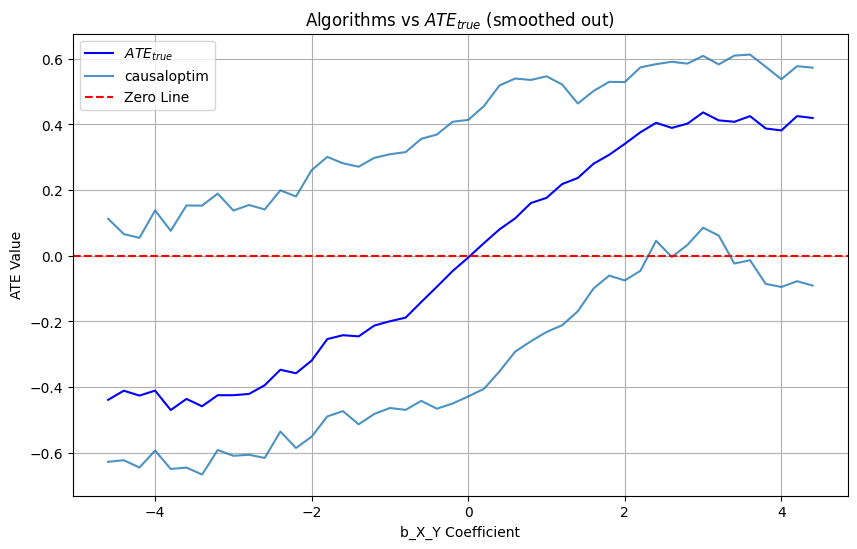

In [36]:
binaryIV.data
algorithms = ['causaloptim', '2SLS', 'autobound', 'entropybounds']
PlottingUtil.print_bound_statistics(binaryIV.data, algorithms)
PlottingUtil.plot_smoothed_ate_vs_bounds(binaryIV.data, algorithms, 5)


In [27]:
invalids = binaryIV.data[binaryIV.data['causaloptim_bound_valid'] == False]
invalIV = BinaryIV('IV Dag', invalids)
invalIV.bound_ate_causaloptim()
invalIV.data

,seed,intercept_X,intercept_Y,b_Z,b_U_X,b_X_Y,b_U_Y,ATE_true,p_Y1_mean,p_Y0_mean,p_U,p_Z,Z,U,X,Y,entropy_Z,entropy_U,entropy_X,entropy_Y,causaloptim_bound_lower,causaloptim_bound_upper,causaloptim_bound_valid,causaloptim_bound_width,causaloptim_bound_failed
2,894119,0,0,1.000304,-2.188701,-4.6,1.031392,-0.705369,0.027072,0.732442,0.974927,0.944672,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, ...","[1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, ...",0.260341,0.141441,0.729856,0.981454,-0.675542,0.111830,False,0.787372,False
4,552404,0,0,-1.369546,-1.798871,-4.2,1.279303,-0.648547,0.038921,0.687468,0.662221,0.159957,"[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...","[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...",0.629503,0.920939,0.760168,0.992774,-0.618660,0.075949,False,0.694609,False
